In [ ]:
pip install streamlit numpy opencv-python scikit-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array


data_dir = '/content/drive/MyDrive/MINI/ACRIMA'
# Load the RIM-ONE dataset
def load_images_and_labels(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, image_filename)
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                images.append(img_array)
                if label.lower() == 'glaucoma':
                    labels.append(1)  # 1 for glaucoma
                else:
                    labels.append(0)  # 0 for normal
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    return np.array(images), np.array(labels)


train_dir = '/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Training'
test_dir = '/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing'

X_train_cnn2, y_train_cnn2 = load_images_and_labels(train_dir)
X_test_cnn2, y_test_cnn2 = load_images_and_labels(test_dir)

X_train_cnn2 = X_train_cnn2 / 255.0  # Normalize and add channel dimension
X_test_cnn2 = X_test_cnn2 / 255.0

# One-hot encode labels for CNN training
y_train_cat2 = to_categorical(y_train_cnn2)

Failed to load /content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Training/glaucoma/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5ff31bc3b0>
Failed to load /content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing/glaucoma/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5ff31faca0>


In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the CNN model
cnn2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train_cnn2)), activation='softmax')
])

cnn2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
cnn2.summary()

# Train the CNN model
hist2 = cnn2.fit(X_train_cnn2, y_train_cat2, epochs=25, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
cnn2.evaluate(X_test_cnn2, to_categorical(y_test_cnn2))
print("Accuracy:" + str(cnn2.evaluate(X_test_cnn2, to_categorical(y_test_cnn2))[1]))

5/5 [==============================] - 6s 1s/step - loss: 0.2308 - accuracy: 0.9007
Accuracy:0.9007092118263245


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load and preprocess the image
img_path = "/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing/glaucoma/Im627_g_ACRIMA.jpg"
img = load_img(img_path, target_size=(224, 224))  # Load with the same target size as training
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Make the prediction and get the class index
prediction = cnn2.predict(img_array)
predicted_class_index = np.argmax(prediction[0])  # Get index for the first (and only) image in the batch

if predicted_class_index == 1:
  print("Glaucoma")
else:
  print("Normal")

1/1 [==============================] - 0s 193ms/step
Glaucoma


Text(0.5, 0, 'Epoch')

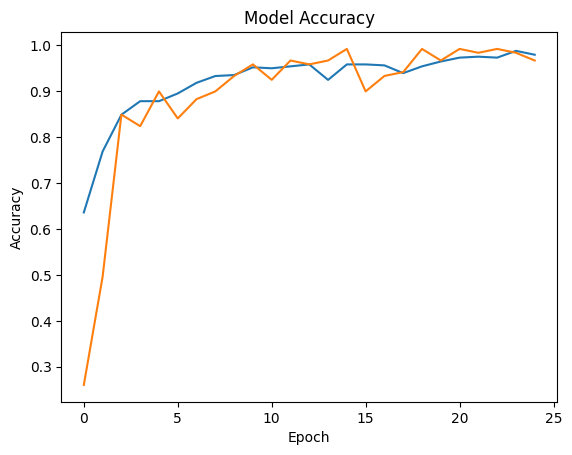

In [ ]:
from matplotlib import pyplot as plt
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
import numpy as np
import cv2
import os
import zipfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array


data_dir = '/content/drive/MyDrive/MINI/ACRIMA'
# Load the RIM-ONE dataset
def load_images_and_labels(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        for image_filename in os.listdir(label_path):
            img_path = os.path.join(label_path, image_filename)
            try:
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                images.append(img_array)
                if label.lower() == 'glaucoma':
                    labels.append(1)  # 1 for glaucoma
                else:
                    labels.append(0)  # 0 for normal
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    return np.array(images), np.array(labels)

train_dir = '/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Training'
test_dir = '/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing'

X_train_lstm2, y_train_lstm2 = load_images_and_labels(train_dir)
X_test_lstm2, y_test_lstm2 = load_images_and_labels(test_dir)

X_train_lstm2 = X_train_lstm2 / 255.0  # Normalize and add channel dimension
X_test_lstm2 = X_test_lstm2 / 255.0

Failed to load /content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Training/glaucoma/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5ff04d1580>
Failed to load /content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing/glaucoma/desktop.ini: cannot identify image file <_io.BytesIO object at 0x7a5fdb2ff5b0>


In [ ]:
X_train_flattened2 = X_train_lstm2.reshape(X_train_lstm2.shape[0], X_train_lstm2.shape[1], -1)
X_test_flattened2 = X_test_lstm2.reshape(X_test_lstm2.shape[0], X_test_lstm2.shape[1], -1)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout

# Build BiLSTM model
model2 = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_flattened2.shape[1], X_train_flattened2.shape[2])),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history2 = model2.fit(X_train_flattened2, y_train_lstm2, epochs=25, batch_size=32, validation_data=(X_test_flattened2, y_test_lstm2))

Epoch 1/25
19/19 [==============================] - 24s 925ms/step - loss: 0.6063 - accuracy: 0.6650 - val_loss: 0.5250 - val_accuracy: 0.7305
Epoch 2/25
19/19 [==============================] - 15s 760ms/step - loss: 0.4973 - accuracy: 0.7626 - val_loss: 0.5102 - val_accuracy: 0.7660
Epoch 3/25
19/19 [==============================] - 14s 714ms/step - loss: 0.4834 - accuracy: 0.7559 - val_loss: 0.4925 - val_accuracy: 0.7730
Epoch 4/25
19/19 [==============================] - 14s 730ms/step - loss: 0.4166 - accuracy: 0.8165 - val_loss: 0.4369 - val_accuracy: 0.7872
Epoch 5/25
19/19 [==============================] - 15s 782ms/step - loss: 0.3812 - accuracy: 0.8300 - val_loss: 0.4340 - val_accuracy: 0.8014
Epoch 6/25
19/19 [==============================] - 15s 770ms/step - loss: 0.3975 - accuracy: 0.8199 - val_loss: 0.3964 - val_accuracy: 0.8156
Epoch 7/25
19/19 [==============================] - 15s 798ms/step - loss: 0.4066 - accuracy: 0.8098 - val_loss: 0.4007 - val_accuracy: 0.8369

In [ ]:
model2.evaluate(X_test_flattened2, y_test_lstm2)
print("Accuracy:" + str(model2.evaluate(X_test_flattened2, y_test_lstm2)[1]))

5/5 [==============================] - 1s 187ms/step - loss: 0.3710 - accuracy: 0.8369
Accuracy:0.8368794322013855


In [ ]:
# Load and preprocess the image
img_path = "/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing/glaucoma/Im627_g_ACRIMA.jpg"
img = load_img(img_path, target_size=(224, 224))  # Load image with the same target size as training
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize
img_array = img_array.reshape(1, 224, -1)  # Reshape to match model input

# Make the prediction
prediction = model2.predict(img_array)

# Interpret the prediction (assuming binary classification)
if prediction > 0.5:
  print("Glaucoma")
else:
  print("Normal")

1/1 [==============================] - 0s 75ms/step
Glaucoma


Text(0.5, 0, 'Epoch')

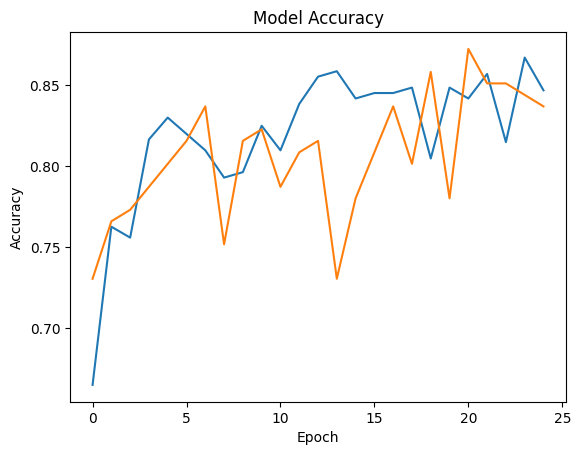

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
from tensorflow.keras.layers import Concatenate

# Combine the outputs of the two models
combined_input2 = Concatenate()([cnn2.output, model2.output])

# Add a dense layer for the final classification
x2 = Dense(64, activation='relu')(combined_input2)
x2 = Dense(1, activation='sigmoid')(x2)

# Final hybrid model


hybrid_model2 = Model(inputs=[cnn2.input, model2.input], outputs=x2)
hybrid_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
result = hybrid_model2.fit([X_train_cnn2, X_train_flattened2], y_train_cnn2, epochs=19, batch_size=32, validation_data=([X_test_cnn2, X_test_flattened2], y_test_cnn2))

Epoch 1/19
19/19 [==============================] - 116s 6s/step - loss: 0.6783 - accuracy: 0.5387 - val_loss: 0.6516 - val_accuracy: 0.5603
Epoch 2/19
19/19 [==============================] - 107s 6s/step - loss: 0.6470 - accuracy: 0.5505 - val_loss: 0.6224 - val_accuracy: 0.5603
Epoch 3/19
19/19 [==============================] - 100s 5s/step - loss: 0.6133 - accuracy: 0.6077 - val_loss: 0.5995 - val_accuracy: 0.8156
Epoch 4/19
19/19 [==============================] - 101s 5s/step - loss: 0.5874 - accuracy: 0.8030 - val_loss: 0.5789 - val_accuracy: 0.7943
Epoch 5/19
19/19 [==============================] - 107s 6s/step - loss: 0.5656 - accuracy: 0.8081 - val_loss: 0.6218 - val_accuracy: 0.6383
Epoch 6/19
19/19 [==============================] - 106s 6s/step - loss: 0.5830 - accuracy: 0.7306 - val_loss: 0.5725 - val_accuracy: 0.7234
Epoch 7/19
19/19 [==============================] - 105s 5s/step - loss: 0.5378 - accuracy: 0.8047 - val_loss: 0.5635 - val_accuracy: 0.7518
Epoch 8/19
19

In [ ]:
print("Accuracy:", result.history['accuracy'][-1])
print("Loss:", result.history['loss'][-1])

Accuracy: 0.8417508602142334
Loss: 0.3751096725463867


In [ ]:
hybrid_model2.save('hybrid_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Text(0.5, 0, 'Epoch')

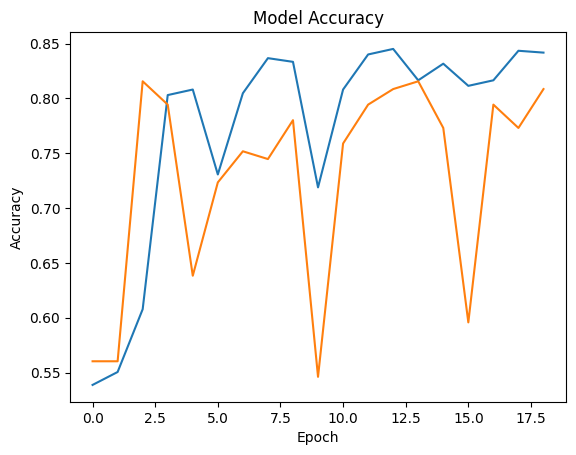

In [ ]:
from matplotlib import pyplot as plt
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = "/content/drive/MyDrive/MINI/ACRIMA/PARTITIONED/Testing/glaucoma/Im627_g_ACRIMA.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
def preprocess_for_cnn(img_array):
    img_array = img_array / 255.0  # Normalize
    return img_array
def preprocess_for_other_model(img_array):
    img_array = img_array.reshape(1, 224, -1)  # Reshape to match model input
    return img_array

img_array_cnn = preprocess_for_cnn(img_array)  # Replace preprocess_for_cnn with your preprocessing function for the CNN branch
img_array_flattened = preprocess_for_other_model(img_array)  # Replace preprocess_for_other_model with your preprocessing function for the other branch

# Make the prediction
prediction = hybrid_model2.predict([img_array_cnn, img_array_flattened])

if prediction > 0.5:
  print("Glaucoma")
else:
  print("Normal")

1/1 [==============================] - 2s 2s/step
Glaucoma
